<a href="https://colab.research.google.com/github/Banafshehkh/Natural-Language-Processing/blob/main/NLP_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Author: Banafsheh Khazali
# Date: March 01, 2023

# **Semantic Text Similarity on Medical Symptoms** 


In [2]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
import requests
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import os
import csv
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage


from sklearn.metrics.pairwise import pairwise_distances


## **Scraping the data**

To scrape the data, We can use Python libraries such as BeautifulSoup and requests. 



In [4]:
# Define the URL of the symptom checker page
url = 'https://www.mayoclinic.org/symptom-checker/select-symptom/itt-20009075'

# Send a GET request to the URL
session = requests.Session()
response = session.get(url, headers={'User-Agent': 'Mozilla/5.0'})

# Parse the HTML content of the response using BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Find the section of the page that contains adult symptoms
adult_symptoms_section = soup.find('div', {'class': 'adult'})
# Check that the adult symptoms section was found
if adult_symptoms_section:
    # Find all links within the adult symptoms section
    adult_symptom_links = adult_symptoms_section.find_all('a', href=True)

    # Extract the URLs from the links
    adult_symptom_urls = [link['href'] for link in adult_symptom_links]

    


# Find the section of the page that contains child symptoms
child_symptoms_section = soup.find('div', {'class': 'child'})

# Check that the child symptoms section was found
if child_symptoms_section:
    # Find all links within the child symptoms section
    child_symptom_links = child_symptoms_section.find_all('a', href=True)

    # Extract the URLs from the links
    child_symptom_urls = [link['href'] for link in child_symptom_links]



# Print the URLs for the adult symptoms
full_adult_url = []
for i in adult_symptom_urls:
  full_adult_url.append("https://www.mayoclinic.org/"+i)

print('\nAdult Symptom URLs:', full_adult_url)

# Print the URLs for the child symptoms
full_child_urls = []
for i in child_symptom_urls:
  full_child_urls.append("https://www.mayoclinic.org/"+i)

print('\nChild Symptom URLs:', full_child_urls)



Adult Symptom URLs: ['https://www.mayoclinic.org//symptom-checker/abdominal-pain-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/blood-in-stool-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/chest-pain-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/constipation-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/cough-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/diarrhea-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/difficulty-swallowing-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/dizziness-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/eye-discomfort-and-redness-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclini

In [5]:
!mkdir corpus

In [6]:
pwd

'/content'

**extract adult symptoms**

In [7]:
# Loop over the URLs and extract the relevant information
for i, url in enumerate(full_adult_url):
#     response = requests.get(url)
    session = requests.Session()
    response = session.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(response.content, 'html.parser')
    adult_symptoms_section = soup.find('div', {'id': 'main-content'})
    
    if adult_symptoms_section is not None:
        name = full_adult_url[i].split('/')[-3].rsplit('-', 1)[0]
        filename = f'{name}.txt'
        with open(f"/content/corpus/{filename}", 'w') as f:
            f.write(adult_symptoms_section.text)
    else:
        print(f"No 'adult' section found on page {i+1}")

**extract children symptoms**

In [8]:
# Loop over the URLs and extract the relevant information
for i, url in enumerate(full_child_urls):
#     response = requests.get(url)
    session = requests.Session()
    response = session.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(response.content, 'html.parser')
    child_symptoms_section = soup.find('div', {'id': 'main-content'})
    
    if child_symptoms_section is not None:
        name = full_child_urls[i].split('/')[-3].rsplit('-', 1)[0]
        filename = f'{name}.txt'
        with open(f"/content/corpus/{filename}", 'w') as f:
            f.write(child_symptoms_section.text)
    else:
        print(f"No 'child' section found on page {i+1}")

## **Preprocessing the data**

To preprocess the data, We may need to clean and tokenize the text, remove stop words, and perform stemming or lemmatization.

In [9]:
!mkdir pre_corpus

**Preprocess adult/child files**

In [10]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    return lemmatized_tokens

# Define the directory where the text files are located
corpus_dir_in = '/content/corpus'
corpus_dir_out = '/content/pre_corpus'

# Create the output directory if it doesn't exist
if not os.path.exists(corpus_dir_out):
    os.makedirs(corpus_dir_out)


# Loop over the input files
for filename in os.listdir(corpus_dir_in):
    if filename.endswith('.txt'):
        # Read the input file
        with open(os.path.join(corpus_dir_in, filename), 'r') as f:
            text = f.read()
        
        # Preprocess the text
        tokens = word_tokenize(text.lower())
        filtered_tokens = [token for token in tokens if token not in stop_words]
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
        preprocessed_text = ' '.join(lemmatized_tokens)
        
        # Write the preprocessed text to a new file
        output_filename = os.path.join(corpus_dir_out, filename)
        with open(output_filename, 'w') as f:
            f.write(preprocessed_text)
            
        print(f'Processed file: {filename}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Processed file: diarrhea-in-children.txt
Processed file: cough-in-children.txt
Processed file: nasal-congestion-in-adults.txt
Processed file: sore-throat-in-children.txt
Processed file: joint-pain-or-muscle-pain-in-children.txt
Processed file: shortness-of-breath-in-adults.txt
Processed file: eye-problems-in-adults.txt
Processed file: constipation-in-adults.txt
Processed file: foot-pain-or-ankle-pain-in-adults.txt
Processed file: shoulder-pain-in-adults.txt
Processed file: low-back-pain-in-adults.txt
Processed file: eye-discomfort-and-redness-in-adults.txt
Processed file: cough-in-adults.txt
Processed file: headaches-in-adults.txt
Processed file: earache-in-children.txt
Processed file: pelvic-pain-in-adult-males.txt
Processed file: nasal-congestion-in-children.txt
Processed file: fever-in-children.txt
Processed file: constipation-in-children.txt
Processed file: nausea-or-vomiting-in-children.txt
Processed file: sore-throat-in-adults.txt
Processed file: neck-pain-in-adults.txt
Processed

## **Calculating the similarity**

Calculate the similarity between the two document-term matrices using a similarity metric such as cosine similarity or Jaccard similarity.

In [11]:
# Define directory path containing text files
dir_path = '/content/pre_corpus'

# Get all text files in directory
file_names = [f for f in os.listdir(dir_path) if f.endswith('.txt')]

# Read contents of each text file and store in a list
corpus = []
for file_name in file_names:
    with open(os.path.join(dir_path, file_name), 'r') as f:
        text = f.read()
        corpus.append(text)

# Calculate TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Compute cosine similarity between all documents
similarity_matrix = cosine_similarity(tfidf_matrix)

# Print similarity matrix.                                                                                                                                                                                                                                                                                     
print(similarity_matrix)

[[1.         0.77421743 0.73077905 ... 0.7425237  0.79511467 0.71223512]
 [0.77421743 1.         0.75531051 ... 0.83576583 0.73396421 0.82657743]
 [0.73077905 0.75531051 1.         ... 0.72205837 0.70234094 0.6904122 ]
 ...
 [0.7425237  0.83576583 0.72205837 ... 1.         0.72051996 0.92706968]
 [0.79511467 0.73396421 0.70234094 ... 0.72051996 1.         0.67798415]
 [0.71223512 0.82657743 0.6904122  ... 0.92706968 0.67798415 1.        ]]


##  Visualize the similarity results using a heatmap or a dendrogram

The dendrogram shows the hierarchical clustering of the documents based on their similarity.

The heatmap shows the similarity matrix as a color-coded grid, where darker colors indicate higher similarity. 

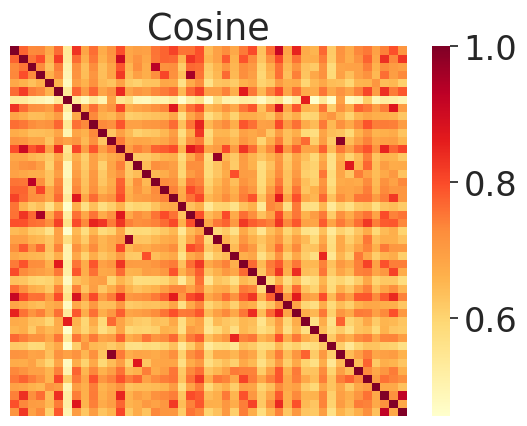

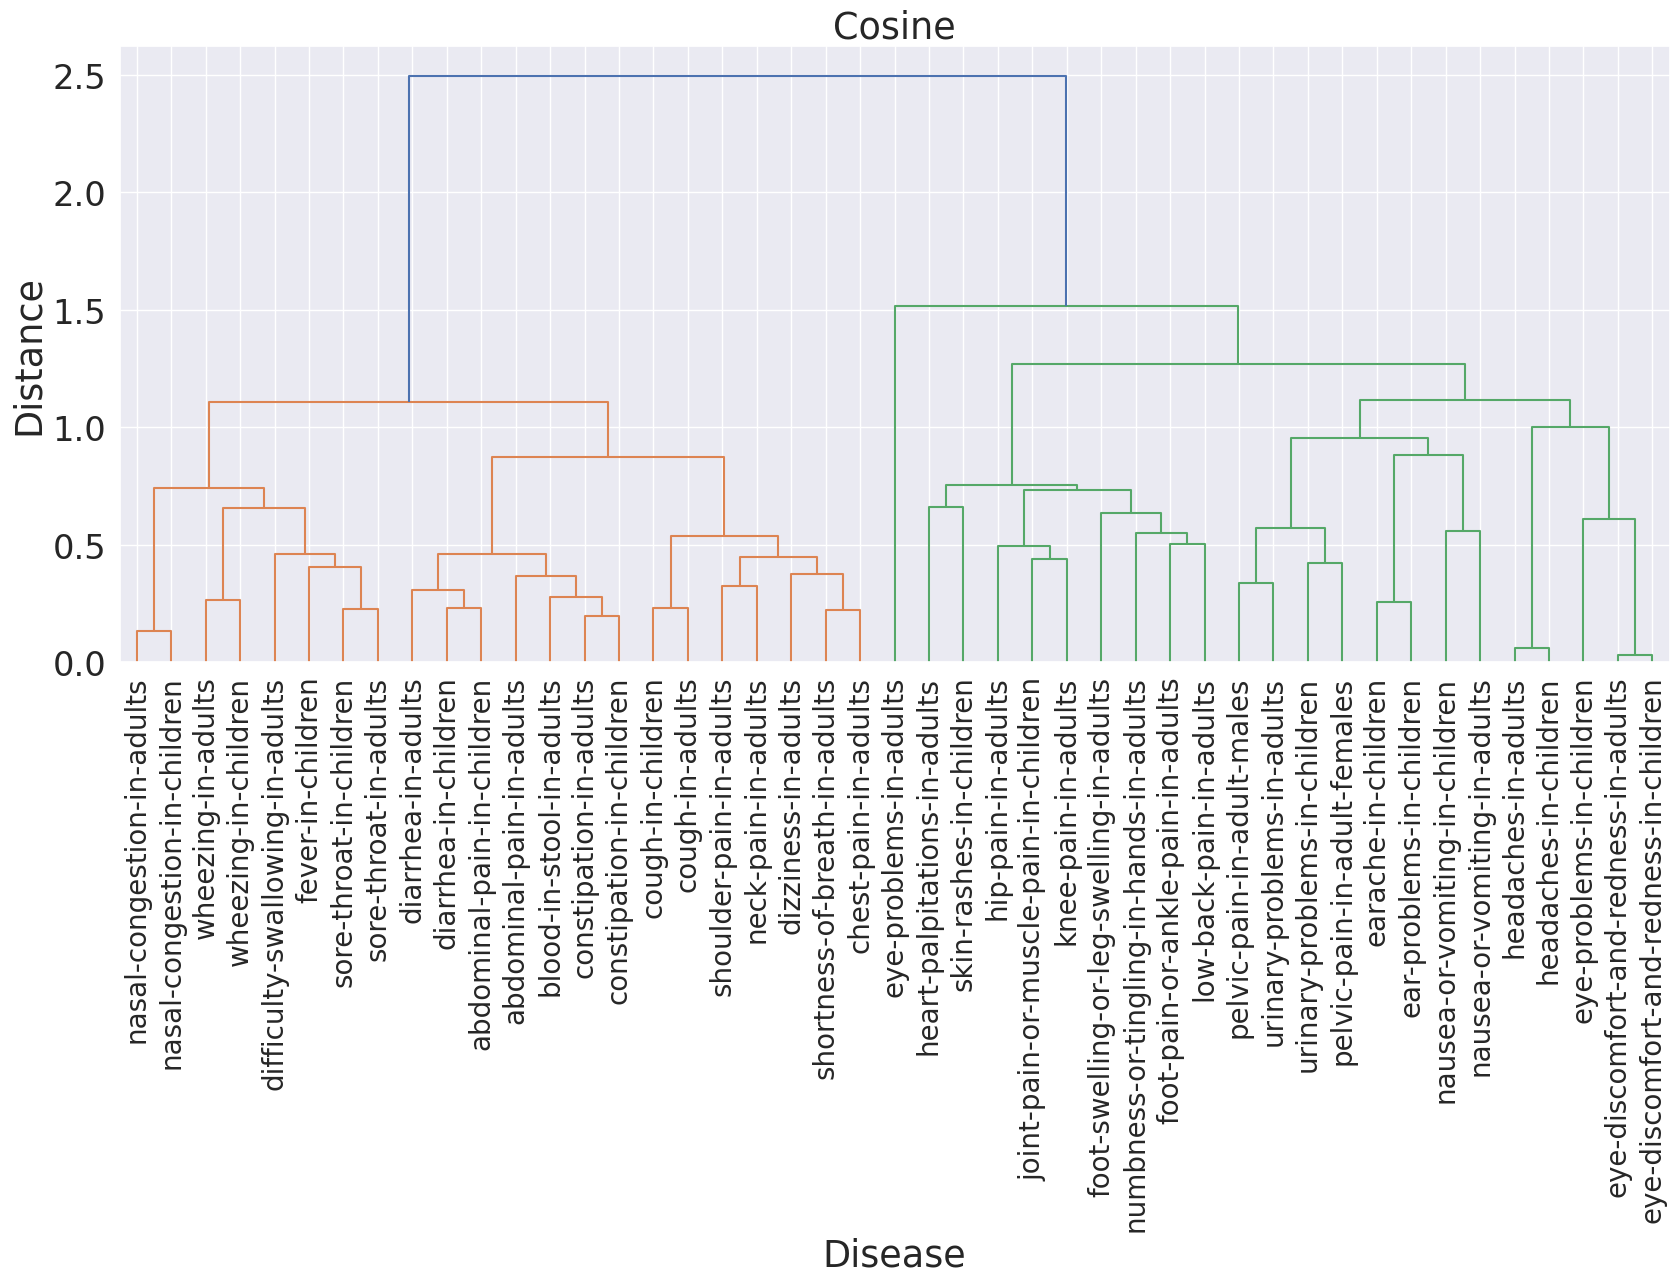

In [13]:
# Create heatmap
sns.set(font_scale=2.2)
sns.heatmap(similarity_matrix, cmap='YlOrRd', xticklabels=False, yticklabels=False)
plt.title('Cosine')
plt.show()


# Create dendrogram
# plt.rcParams.update({'font.size': 100})
plt.figure(figsize=(20, 8))
f_names = [i.split('.')[0] for i in file_names]
dendrogram = hierarchy.dendrogram(hierarchy.linkage(similarity_matrix, method='ward'), labels =f_names )
plt.xticks(fontsize= 20)
plt.title('Cosine')
plt.xlabel('Disease')
plt.ylabel('Distance')
plt.show()

## **Find Similar Diseases**

Using clustering algorithms such as K-means clustering or Hierarchical clustering to find similar diseases in the document.

In [14]:
# Cluster documents using K-means
num_clusters = 3
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

# Print the top 5 documents in each cluster
for i in range(num_clusters):
    print(f"Cluster {i}:")
    cluster_indices = np.where(km.labels_ == i)[0]
    cluster_similarity_scores = similarity_matrix[cluster_indices][:, cluster_indices]
    cluster_top_indices = np.argsort(-cluster_similarity_scores.sum(axis=1))[:5]
    for j in cluster_top_indices:
        print(f"- Document {cluster_indices[j]}: {os.listdir(dir_path)[cluster_indices[j]]}")

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
- Document 30: diarrhea-in-adults.txt
- Document 0: diarrhea-in-children.txt
- Document 7: constipation-in-adults.txt
- Document 32: abdominal-pain-in-children.txt
- Document 18: constipation-in-children.txt
Cluster 1:
- Document 21: neck-pain-in-adults.txt
- Document 12: cough-in-adults.txt
- Document 5: shortness-of-breath-in-adults.txt
- Document 20: sore-throat-in-adults.txt
- Document 1: cough-in-children.txt
Cluster 2:
- Document 37: eye-discomfort-and-redness-in-children.txt
- Document 11: eye-discomfort-and-redness-in-adults.txt
- Document 33: eye-problems-in-children.txt
- Document 6: eye-problems-in-adults.txt


Clustering Methods:

*   Agglomerative Hierarchical Clustering
*   DBSCAN
*   Spectral Clustering
*   Spectral Clustering
*   Affinity Propagation

Distance Metrics:


*   Euclidean Distance

*   Manhattan Distance
*   Cosine Similarity


*   Jaccard Similarity







In [15]:
# Calculate TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Compute cosine similarity between all documents
similarity_matrix = 1 - cosine_similarity(tfidf_matrix)

# Print similarity matrix.                                                                                                                                                                                                                                                                                     
print(similarity_matrix)

[[-4.44089210e-16  2.25782570e-01  2.69220948e-01 ...  2.57476295e-01
   2.04885334e-01  2.87764878e-01]
 [ 2.25782570e-01  0.00000000e+00  2.44689493e-01 ...  1.64234172e-01
   2.66035785e-01  1.73422571e-01]
 [ 2.69220948e-01  2.44689493e-01 -2.22044605e-16 ...  2.77941625e-01
   2.97659062e-01  3.09587797e-01]
 ...
 [ 2.57476295e-01  1.64234172e-01  2.77941625e-01 ...  0.00000000e+00
   2.79480040e-01  7.29303205e-02]
 [ 2.04885334e-01  2.66035785e-01  2.97659062e-01 ...  2.79480040e-01
  -2.22044605e-16  3.22015851e-01]
 [ 2.87764878e-01  1.73422571e-01  3.09587797e-01 ...  7.29303205e-02
   3.22015851e-01  0.00000000e+00]]


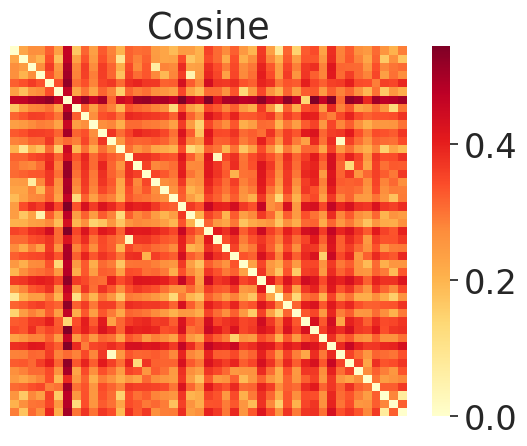

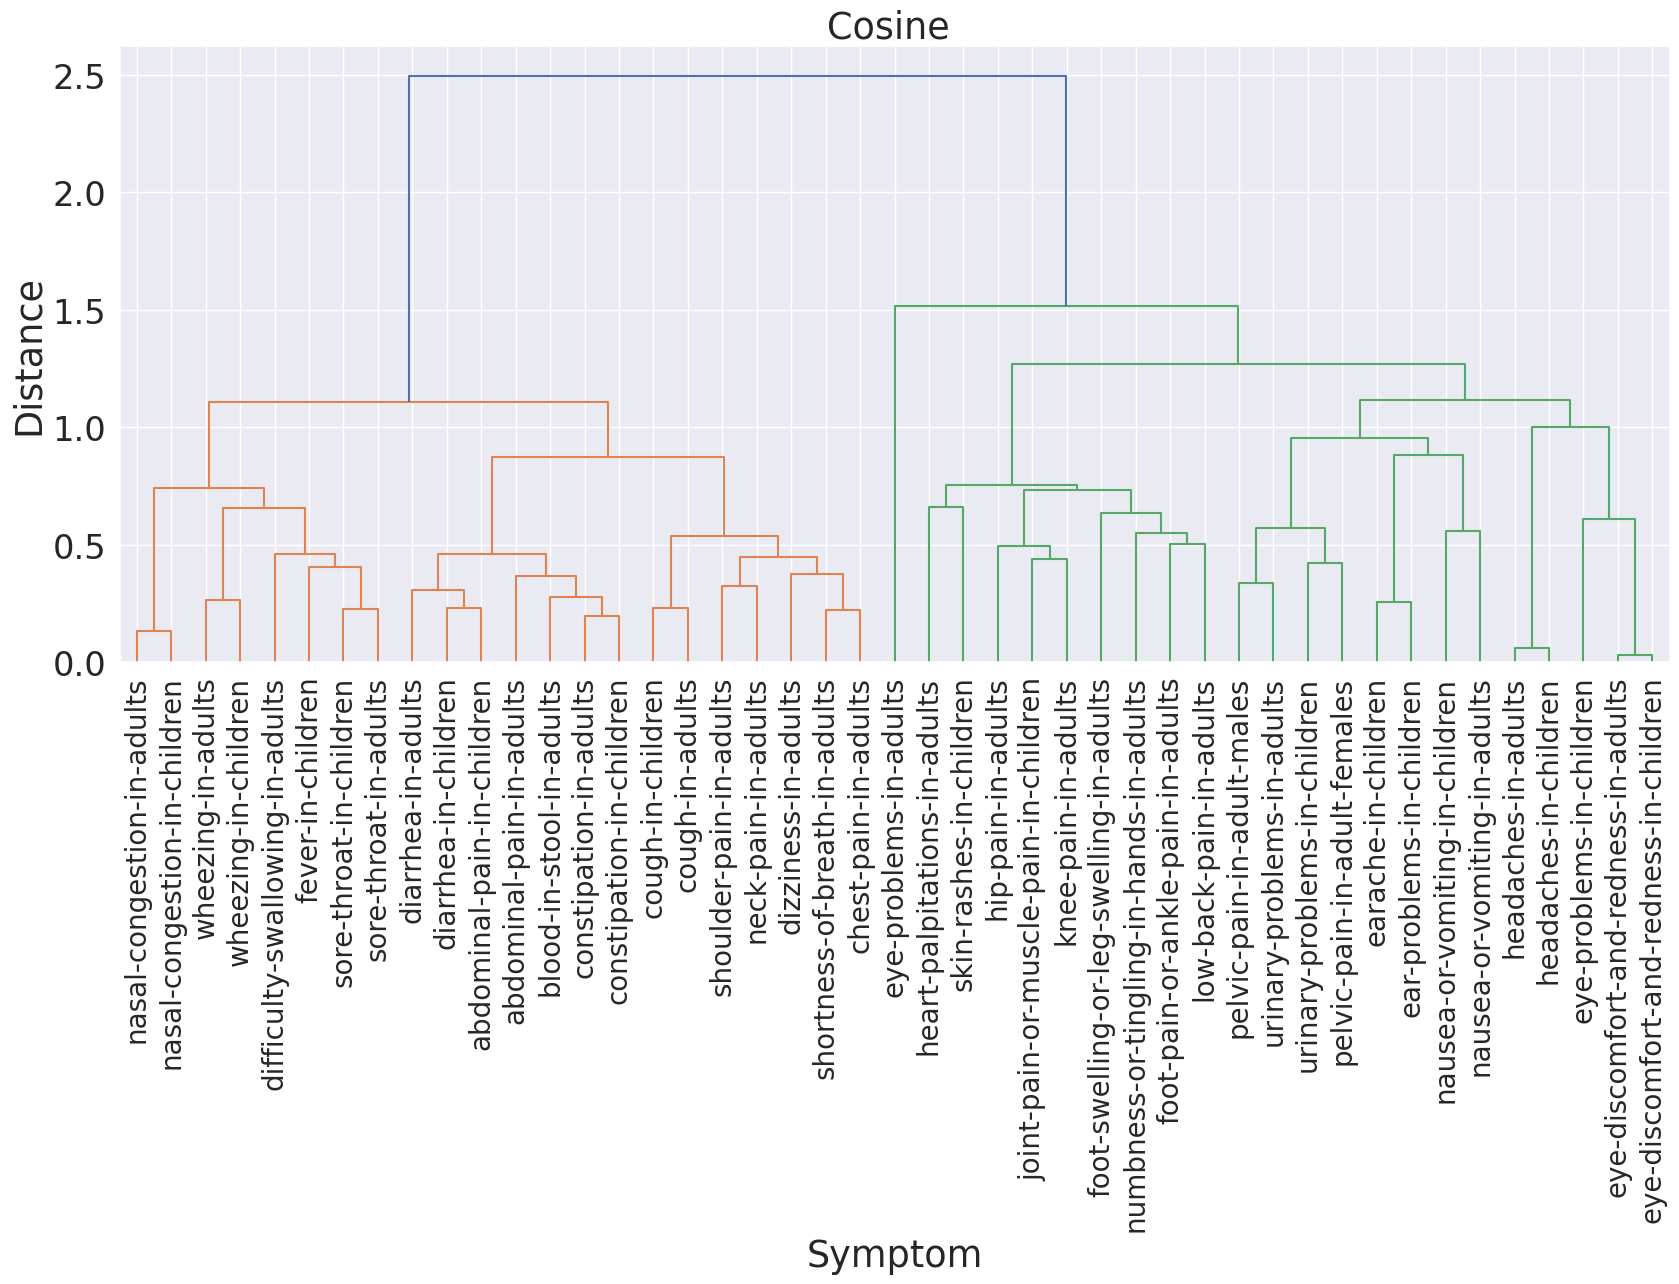

In [21]:
# Create heatmap
sns.set(font_scale=2.2)
sns.heatmap(similarity_matrix, cmap='YlOrRd', xticklabels=False, yticklabels=False)
plt.title('Cosine')
plt.show()


# Create dendrogram
# plt.rcParams.update({'font.size': 100})
plt.figure(figsize=(20, 8))
f_names = [i.split('.')[0] for i in file_names]
dendrogram = hierarchy.dendrogram(hierarchy.linkage(similarity_matrix, method='ward'), labels =f_names )
plt.xticks(fontsize= 20)
plt.title('Cosine ')
plt.xlabel('Symptom')
plt.ylabel('Distance')
plt.show()

jaccard similarity

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


[[1.         0.63578275 0.65753425 ... 0.59874608 0.68275862 0.56432749]
 [0.63578275 1.         0.70731707 ... 0.70860927 0.63036304 0.72292994]
 [0.65753425 0.70731707 1.         ... 0.66552901 0.66428571 0.64423077]
 ...
 [0.59874608 0.70860927 0.66552901 ... 1.         0.61842105 0.82711864]
 [0.68275862 0.63036304 0.66428571 ... 0.61842105 1.         0.55722892]
 [0.56432749 0.72292994 0.64423077 ... 0.82711864 0.55722892 1.        ]]


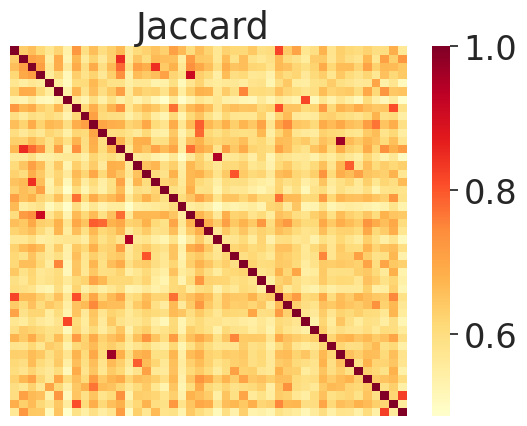

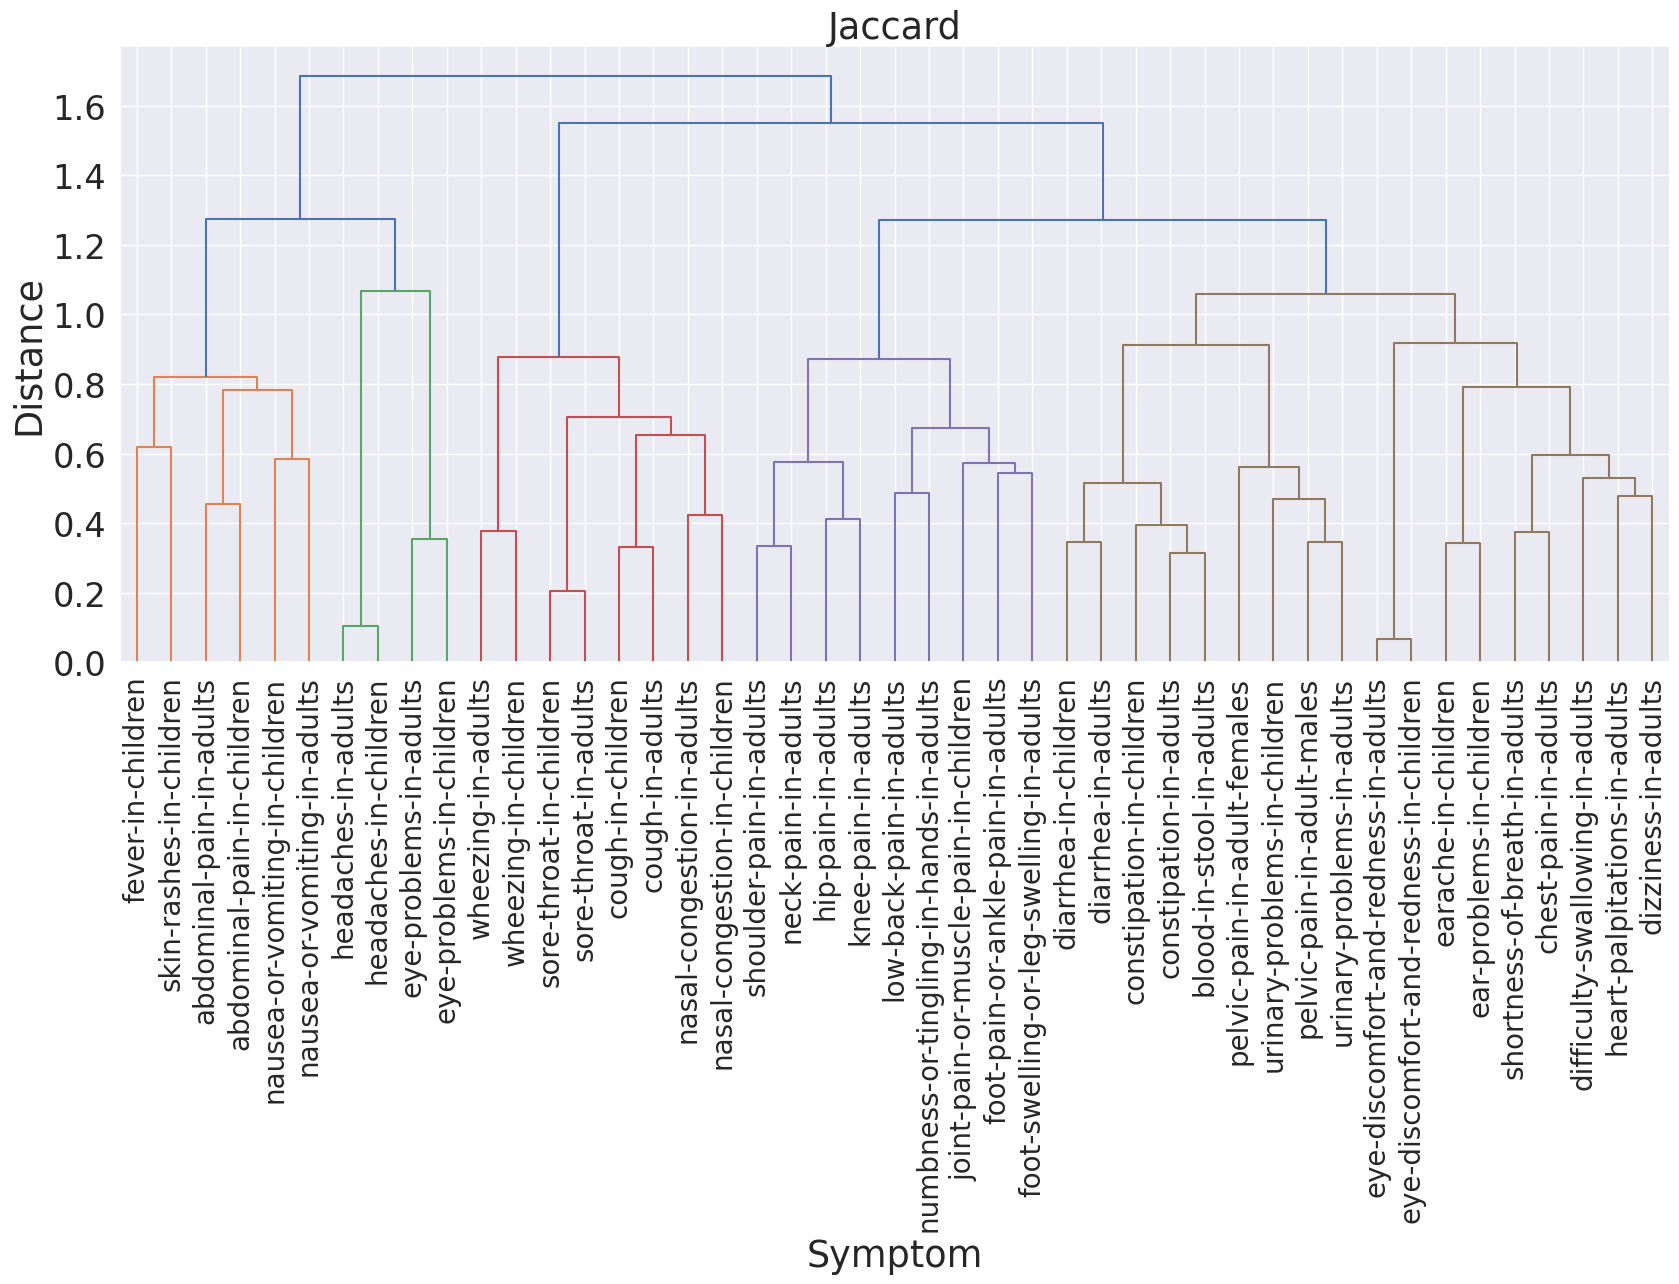

In [22]:
# Create a TfidfVectorizer with the Jaccard similarity metric
vectorizer = TfidfVectorizer(use_idf=False, norm='l2', binary=True)
tfidf_matrix = vectorizer.fit_transform(corpus)

# Convert the sparse matrix to a dense matrix
dense_matrix = tfidf_matrix.toarray()

# Calculate the pairwise Jaccard similarity matrix
jaccard_similarity_matrix = 1 - pairwise_distances(dense_matrix, metric='jaccard')

# Print the pairwise Jaccard similarity matrix
print(jaccard_similarity_matrix)



# Create heatmap
sns.set(font_scale=2.2)
sns.heatmap(jaccard_similarity_matrix, cmap='YlOrRd', xticklabels=False, yticklabels=False)
plt.title('Jaccard ')
plt.show()


# Create dendrogram
# plt.rcParams.update({'font.size': 100})
plt.figure(figsize=(20, 8))
f_names = [i.split('.')[0] for i in file_names]
dendrogram = hierarchy.dendrogram(hierarchy.linkage(jaccard_similarity_matrix, method='ward'), labels =f_names )
plt.xticks(fontsize= 20)
plt.title('Jaccard')
plt.xlabel('Symptom')
plt.ylabel('Distance')
plt.show()

manhatan

[[0.         0.6219896  0.65481015 ... 0.68007594 0.57924824 0.82917551]
 [0.6219896  0.         0.59474069 ... 0.49364837 0.6934262  0.5722524 ]
 [0.65481015 0.59474069 0.         ... 0.65216666 0.64001353 0.79385107]
 ...
 [0.68007594 0.49364837 0.65216666 ... 0.         0.69973068 0.36541382]
 [0.57924824 0.6934262  0.64001353 ... 0.69973068 0.         0.89264428]
 [0.82917551 0.5722524  0.79385107 ... 0.36541382 0.89264428 0.        ]]


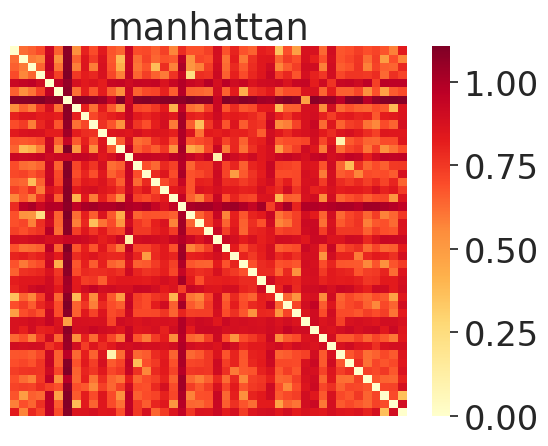

<ipython-input-23-db30fc1a264a>:23: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = hierarchy.dendrogram(hierarchy.linkage(manhattan_distance_matrix, method='ward'), labels =f_names )


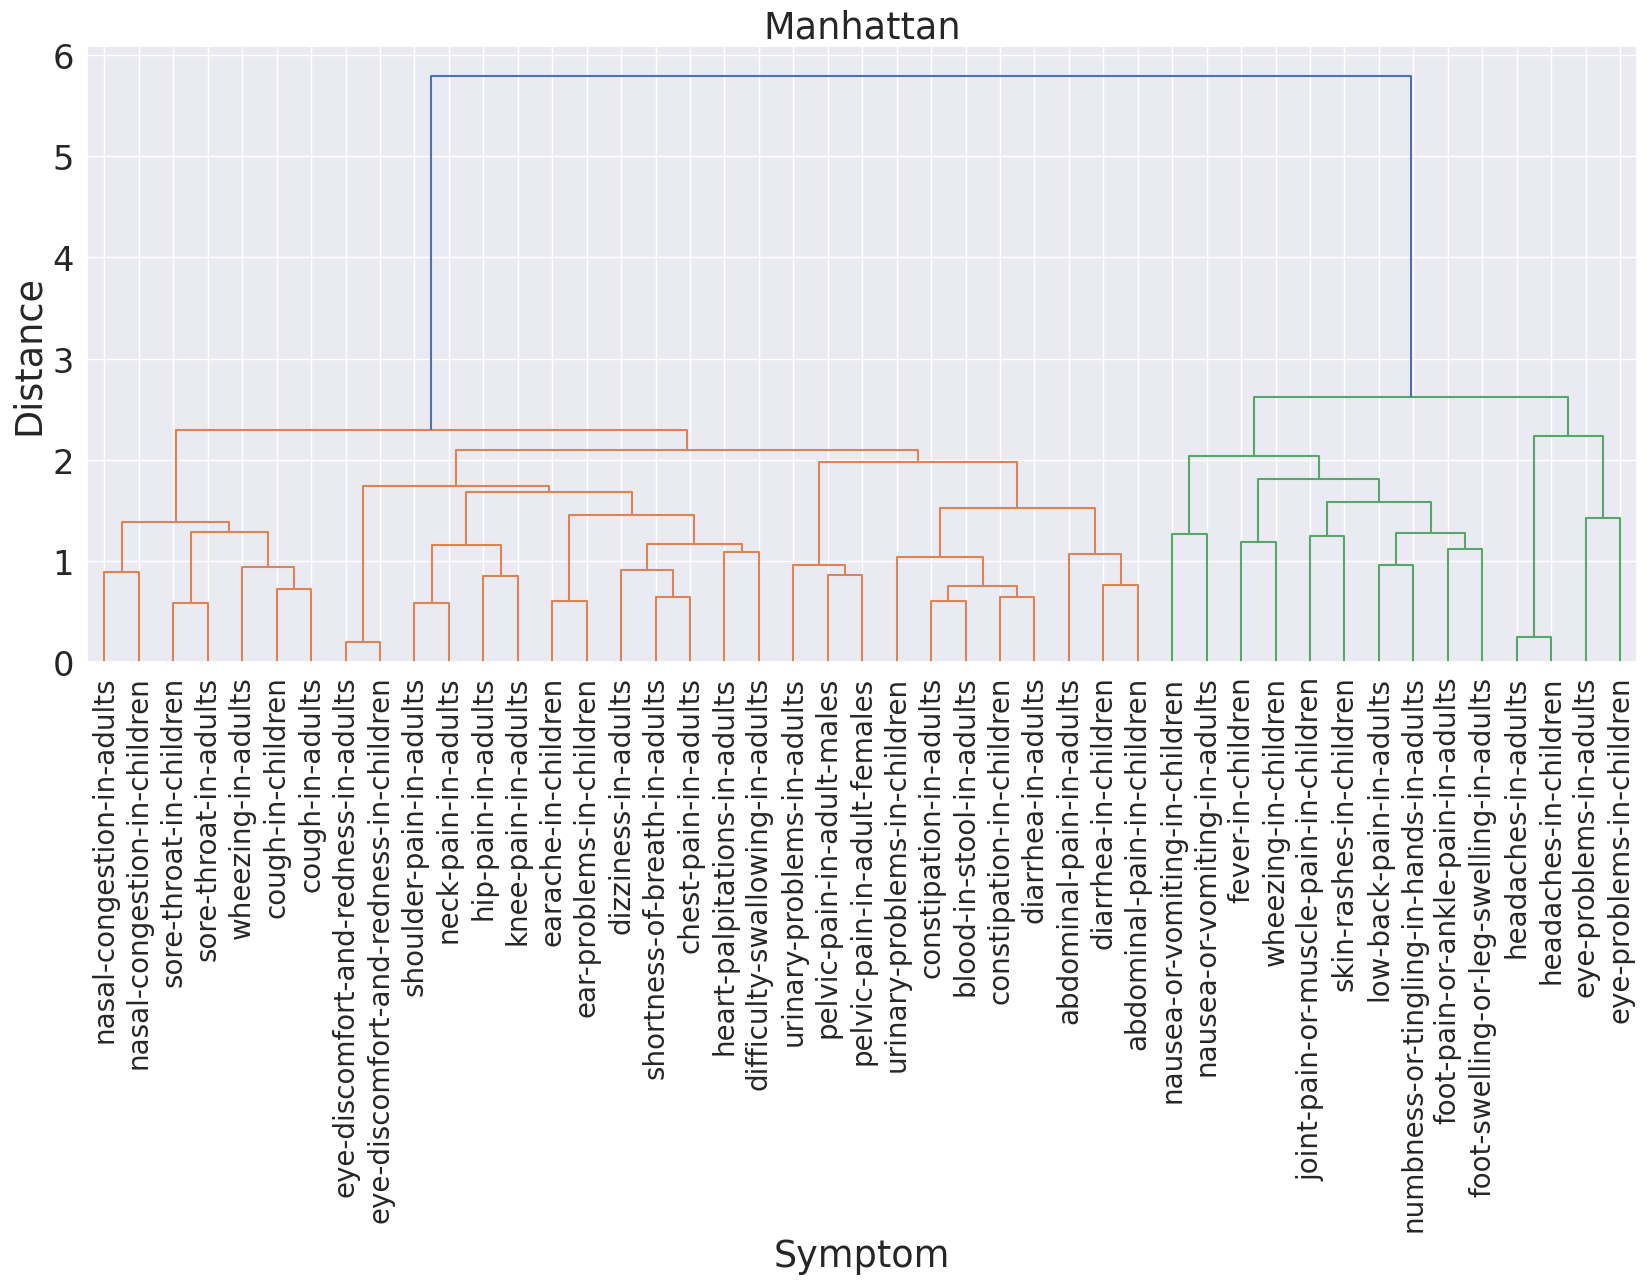

In [23]:
# Create a TfidfVectorizer with the Manhattan distance metric
vectorizer = TfidfVectorizer(use_idf=True, norm='l1')
tfidf_matrix = vectorizer.fit_transform(corpus)

# Calculate the pairwise Manhattan distance matrix
manhattan_distance_matrix = pairwise_distances(tfidf_matrix, metric='manhattan')

# Print the pairwise Manhattan distance matrix
print(manhattan_distance_matrix)

# Create heatmap
sns.set(font_scale=2.2)
sns.heatmap(manhattan_distance_matrix, cmap='YlOrRd', xticklabels=False, yticklabels=False)
plt.title('manhattan')
plt.show()



# Create dendrogram
# plt.rcParams.update({'font.size': 100})
plt.figure(figsize=(20, 8))
f_names = [i.split('.')[0] for i in file_names]
dendrogram = hierarchy.dendrogram(hierarchy.linkage(manhattan_distance_matrix, method='ward'), labels =f_names )
plt.xticks(fontsize= 20)
plt.title('Manhattan')
plt.xlabel('Symptom')
plt.ylabel('Distance')
plt.show()

Euclidean Distance

[[0.         0.67198597 0.733786   ... 0.71760197 0.64013332 0.75863677]
 [0.67198597 0.         0.69955628 ... 0.57312158 0.72943236 0.5889356 ]
 [0.733786   0.69955628 0.         ... 0.74557578 0.77156861 0.78687711]
 ...
 [0.71760197 0.57312158 0.74557578 ... 0.         0.74763633 0.38191706]
 [0.64013332 0.72943236 0.77156861 ... 0.74763633 0.         0.80251586]
 [0.75863677 0.5889356  0.78687711 ... 0.38191706 0.80251586 0.        ]]


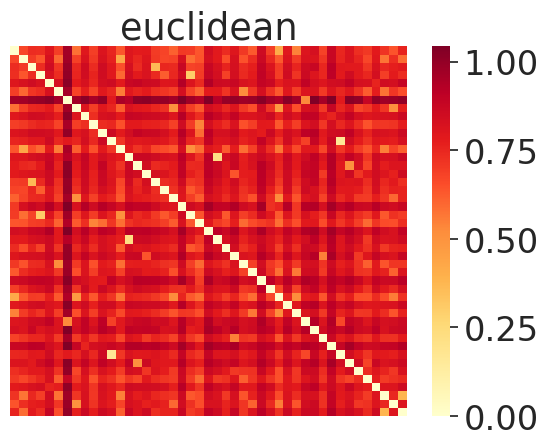

<ipython-input-24-5b0b43c48e23>:24: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = hierarchy.dendrogram(hierarchy.linkage(euclidean_distance_matrix, method='ward'), labels =f_names )


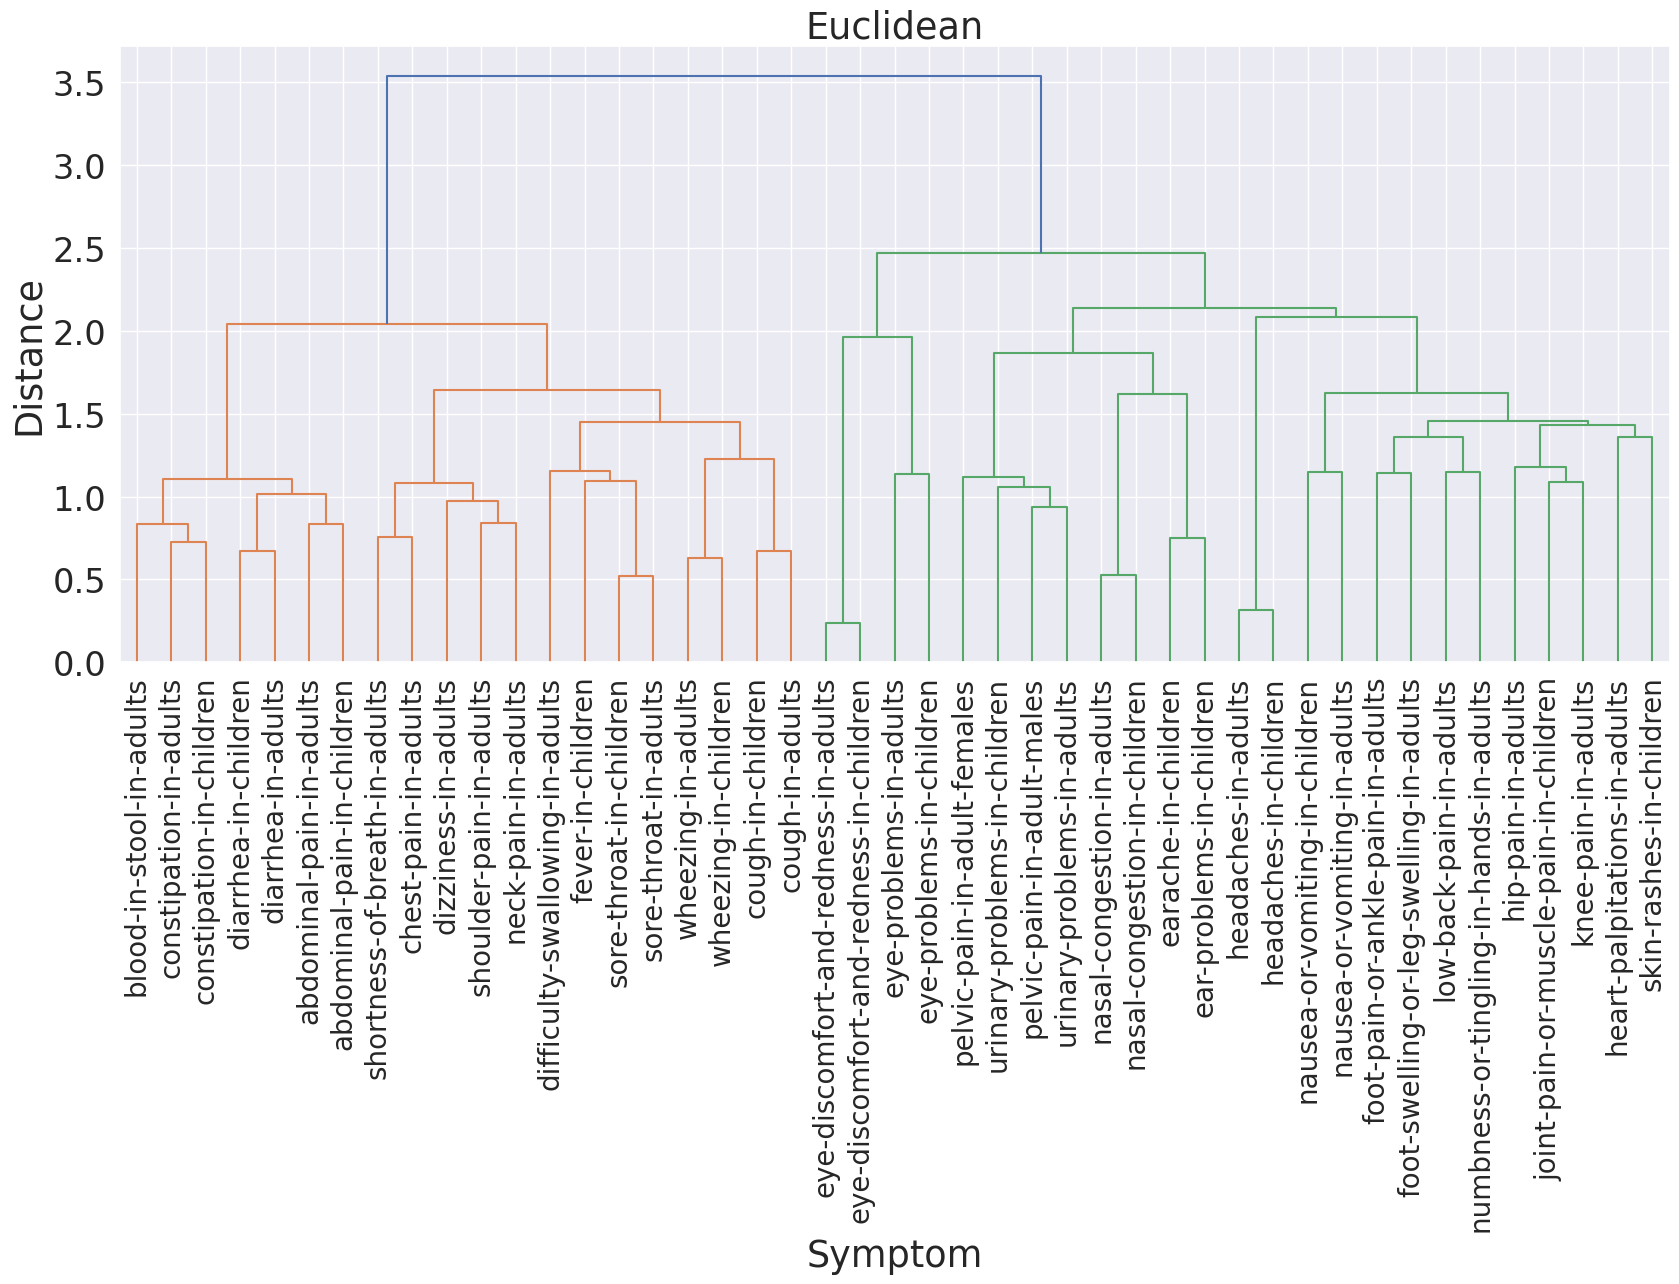

In [24]:
# Create a TfidfVectorizer with the Euclidean distance metric
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Calculate the pairwise Euclidean distance matrix
euclidean_distance_matrix = pairwise_distances(tfidf_matrix, metric='euclidean')

# Print the pairwise Euclidean distance matrix
print(euclidean_distance_matrix)


# Create heatmap
sns.set(font_scale=2.2)
sns.heatmap(euclidean_distance_matrix, cmap='YlOrRd', xticklabels=False, yticklabels=False)
plt.title('euclidean')
plt.show()



# Create dendrogram
# plt.rcParams.update({'font.size': 100})
plt.figure(figsize=(20, 8))
f_names = [i.split('.')[0] for i in file_names]
dendrogram = hierarchy.dendrogram(hierarchy.linkage(euclidean_distance_matrix, method='ward'), labels =f_names )
plt.xticks(fontsize= 20)
plt.title('Euclidean')
plt.xlabel('Symptom')
plt.ylabel('Distance')
plt.show()
